In [1]:
from pathlib import Path
import torch
from lerobot.common.datasets.lerobot_dataset import LeRobotDataset
from lerobot.common.policies.diffusion.configuration_diffusion import DiffusionConfig
from lerobot.common.policies.diffusion.modeling_diffusion import DiffusionPolicy
import numpy as np
import matplotlib.pyplot as plt
import time 
import datetime

/home/ns1254/miniforge3/envs/lerobot/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda")

In [3]:
pretrained_policy_path=Path("/home/ns1254/lerobot/examples/outputs/train/example_lift_diffusion_2024-11-11_06-03/checkpoint_15000.pt/")

In [4]:
policy = DiffusionPolicy.from_pretrained(pretrained_policy_path)
policy.eval()
policy.to(device)
pass

Loading weights from local directory


In [5]:
# Set up the dataset.
delta_timestamps = {
    # Load the previous image and state at -0.1 seconds before current frame,
    # then load current image and state corresponding to 0.0 second.
    "observation.images.agentview_image": [-0.1, 0.0],
    "observation.images.robot0_eye_in_hand_image": [-0.1, 0.0],
    "observation.robot0_eef_pos": [-0.1, 0.0],
    "observation.robot0_eef_quat": [-0.1, 0.0],
    "observation.robot0_gripper_qpos": [-0.1, 0.0],
    "observation.state": [-0.1, 0.0],
    # Load the previous action (-0.1), the next action to be executed (0.0),
    # and 14 future actions with a 0.1 seconds spacing. All these actions will be
    # used to supervise the policy.
    "action": [-0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4],
}
# dataset = LeRobotDataset("lerobot/pusht", delta_timestamps=delta_timestamps)

In [6]:
local_dir = Path("/home/ns1254/lerobot/data") 
dataset = LeRobotDataset(repo_id="lift", root=local_dir, delta_timestamps=delta_timestamps)

In [7]:
demo_id=10
rows=[]
for i in range(len(dataset)):
    row=dataset[i]
    if row['episode_index'].numpy()!=demo_id:
        continue 
    rows.append(row)

for i in range(len(rows)):
    assert i==rows[i]['frame_index'].numpy()

len(rows)

57

In [8]:
actions_org=[]
for row in rows:
    actions_org.append(row['action'][0].numpy())

actions_org=np.array(actions_org)
actions_org.shape

(57, 7)

In [9]:
input_shapes = {'observation.images.agentview_image': (3, 84, 84), 'observation.images.robot0_eye_in_hand_image': (3, 84, 84), 
                'observation.robot0_eef_pos': (3,), 'observation.robot0_eef_quat': (4,), 'observation.robot0_gripper_qpos': (2,),
                'observation.state': (32,)}

output_shapes = {'action': (7,)}

In [10]:
action_pred=[]
for row in rows:
    input_batch = {k: v.to(device) for k, v in row.items() if k in input_shapes} 
    output_dict = policy.select_action(input_batch)
    action_pred.append(output_dict[0].cpu().numpy())

In [11]:
action_pred=np.array(action_pred)
action_pred.shape

(57, 7)

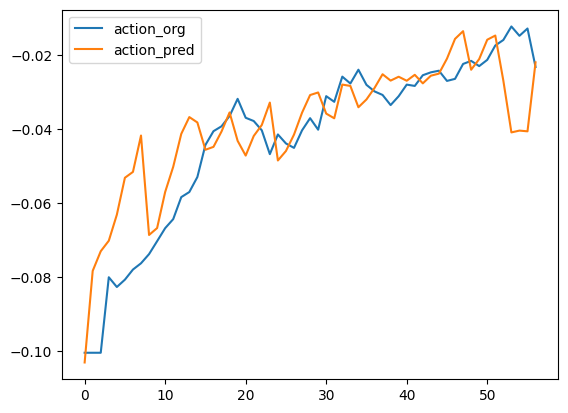

In [12]:
plt.plot(actions_org[:, 0], label="action_org")
plt.plot(action_pred[:, 0], label="action_pred")
plt.legend()

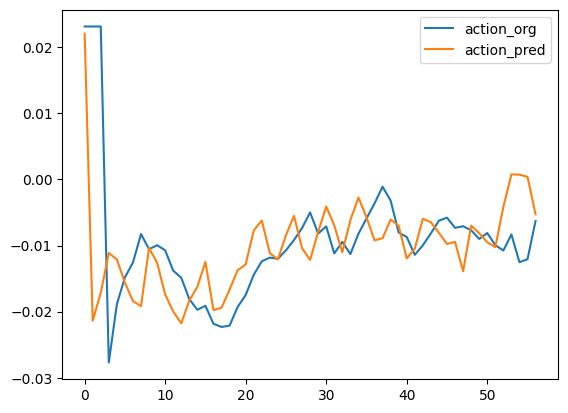

In [13]:
plt.plot(actions_org[:, 1], label="action_org")
plt.plot(action_pred[:, 1], label="action_pred")
plt.legend()

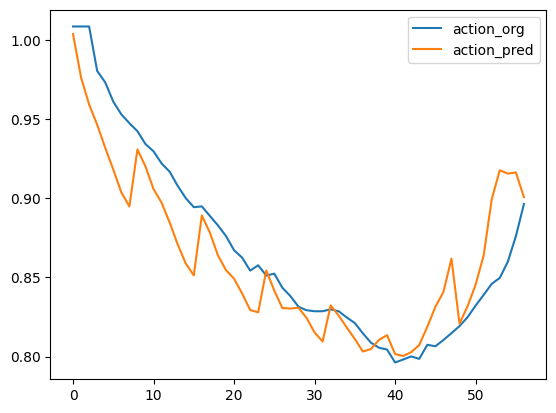

In [14]:
plt.plot(actions_org[:, 2], label="action_org")
plt.plot(action_pred[:, 2], label="action_pred")
plt.legend()

In [15]:
for k,v in input_batch.items():
    print(k,v.shape)

observation.robot0_eef_pos torch.Size([2, 3])
observation.robot0_eef_quat torch.Size([2, 4])
observation.robot0_gripper_qpos torch.Size([2, 2])
observation.state torch.Size([2, 32])
observation.images.agentview_image torch.Size([2, 3, 84, 84])
observation.images.robot0_eye_in_hand_image torch.Size([2, 3, 84, 84])


### robomimic env evaluation

In [19]:
import json
import numpy as np
import time
import os 
import psutil 
from collections import OrderedDict

import torch
from torch.utils.data import DataLoader
 
import robomimic.utils.train_utils as TrainUtils
import robomimic.utils.torch_utils as TorchUtils
import robomimic.utils.tensor_utils as TensorUtils
import robomimic.utils.obs_utils as ObsUtils
import robomimic.utils.env_utils as EnvUtils
import robomimic.utils.file_utils as FileUtils
from robomimic.config import config_factory
from robomimic.algo import algo_factory, RolloutPolicy
from robomimic.utils.log_utils import PrintLogger, DataLogger, flush_warnings
import imageio 

import matplotlib.pyplot as plt
import h5py

In [17]:
ckpt_path = "/home/ns1254/robomimic/bc_transformer_trained_models/test/20230811114334/models/model_epoch_240_Lift_success_0.78.pth"
assert os.path.exists(ckpt_path)

device = TorchUtils.get_torch_device(try_to_use_cuda=True) 
device = TorchUtils.get_torch_device(try_to_use_cuda=True)

# restore policy
policy, ckpt_dict = FileUtils.policy_from_checkpoint(ckpt_path=ckpt_path, device=device, verbose=False)
ckpt_dict = FileUtils.maybe_dict_from_checkpoint(ckpt_path=ckpt_path, ckpt_dict=None)
# algo name and config from model dict
algo_name, _ = FileUtils.algo_name_from_checkpoint(ckpt_dict=ckpt_dict)
config, _ = FileUtils.config_from_checkpoint(algo_name=algo_name, ckpt_dict=ckpt_dict, verbose=False)

/home/ns1254/lerobot/envs/robomimic/robomimic/utils/file_utils.py:186: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt_dict = torch.load(ckpt_path)
/home/ns1254/miniforge


============= Initialized Observation Utils with Obs Spec =============

using obs modality: low_dim with keys: ['robot0_eef_quat', 'object', 'robot0_gripper_qpos', 'robot0_eef_pos']
using obs modality: rgb with keys: ['robot0_eye_in_hand_image', 'agentview_image']
using obs modality: depth with keys: []
using obs modality: scan with keys: []
Created GPT_Backbone model with number of parameters: 18906112


In [26]:
dataset_path="/home/ns1254/data_robomimic/nn/lift_image_v141_20p.hdf5"
f = h5py.File(dataset_path, "r")
env_meta = json.loads(f["data"].attrs["env_args"])
# f.close()

In [30]:
np.set_printoptions(precision=4, suppress=True)

In [31]:
demo=f["data"]["demo_0"]
states=demo["states"]
states[0]

array([ 0.    ,  0.0147,  0.1946, -0.0083, -2.6541, -0.0003,  2.9488,
        0.7934,  0.0208, -0.0208,  0.0219,  0.0224,  0.8308,  0.8362,
        0.    ,  0.    ,  0.5484,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,  0.    ,
        0.    ,  0.    ,  0.    ,  0.    ])

In [33]:
demo['obs']['object'][0]

array([ 0.0219,  0.0224,  0.8308,  0.    ,  0.    ,  0.5484,  0.8362,
       -0.1422, -0.0199,  0.1708])

In [35]:
demo['obs']['robot0_eef_pos'][0]

array([-0.1202,  0.0025,  1.0016])

In [22]:
env = EnvUtils.create_env_from_metadata(
    env_meta=env_meta,  
    render=False, 
    render_offscreen=True,
    use_image_obs=True,
    use_depth_obs=False,
)
dummy_spec = dict(  obs=dict( low_dim=['robot0_eef_pos', 'robot0_eef_quat', 'robot0_gripper_qpos'], rgb=['agentview_image', 'robot0_eye_in_hand_image'], ),)
ObsUtils.initialize_obs_utils_with_obs_specs(obs_modality_specs=dummy_spec)

[robosuite WARNING] No private macro file found! (macros.py:53)
[robosuite WARNING] It is recommended to use a private macro file (macros.py:54)
[robosuite WARNING] To setup, run: python /home/ns1254/lerobot/envs/robosuite/robosuite/scripts/setup_macros.py (macros.py:55)


Created environment with name Lift
Action size is 7

============= Initialized Observation Utils with Obs Spec =============

using obs modality: low_dim with keys: ['robot0_eef_quat', 'robot0_gripper_qpos', 'robot0_eef_pos']
using obs modality: rgb with keys: ['robot0_eye_in_hand_image', 'agentview_image']


In [23]:
obs = env.reset()
state_dict = env.get_state()

# hack that is necessary for robosuite tasks for deterministic action playback
obs = env.reset_to(state_dict)

In [25]:
# obs.keys()
for key in obs.keys():
    print(key, obs[key].shape)

agentview_image (3, 84, 84)
robot0_eye_in_hand_image (3, 84, 84)
object (10,)
robot0_joint_pos (7,)
robot0_joint_pos_cos (7,)
robot0_joint_pos_sin (7,)
robot0_joint_vel (7,)
robot0_eef_pos (3,)
robot0_eef_quat (4,)
robot0_eef_vel_lin (3,)
robot0_eef_vel_ang (3,)
robot0_gripper_qpos (2,)
robot0_gripper_qvel (2,)


In [21]:
from collections import deque
class FrameStackForTrans:
    def __init__(self, num_frames):
        self.num_frames = num_frames
        self.obs_history = {}
        
    def reset(self, init_obs):
        """ 
        init_obs: dict of initial observation at the start of the episode
        return stacked obs by repeating the first observation num_frames times
        """
        
        self.obs_history = {}
        for k in init_obs:
            self.obs_history[k] = deque([init_obs[k][None] for _ in range(self.num_frames)], maxlen=self.num_frames,)
        obs = { k : np.concatenate(self.obs_history[k], axis=0) for k in self.obs_history }
        return obs 

    def add_new_obs(self, new_obs):
        """ 
        new_obs: dict of new observation at current timestep
        return stacked obs
        """
        for k in new_obs:
            if 'timesteps' in k or 'actions' in k: continue
            self.obs_history[k].append(new_obs[k][None])

        obs= { k : np.concatenate(self.obs_history[k], axis=0) for k in self.obs_history }
        return obs 

In [26]:
obs['agentview_image'].shape

(10, 3, 84, 84)

In [22]:
framestacker=FrameStackForTrans(num_frames=2)

In [ ]:
obs_0={k:obss[k][0] for k in obss.keys()}
for key in obs_0.keys():
    if 'image' in key:
        obs_0[key]=obs_0[key].transpose(2, 1, 0)
 
obs=framestacker.reset(obs_0)
obs['agentview_image'].shape

In [ ]:
obs=framestacker.add_new_obs(next_obs)